In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, cycle
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
from torch.utils.data import DataLoader, random_split
import einops

import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys
# TODO Chris: I had this notebook in code/geometric_database/notebook/PIT_library, adjust the sys import accordingly
sys.path.append("../") # go to parent dir

In [4]:
# %matplotlib notebook
%matplotlib inline
from dataloaders.detic_labeled_habitat import DeticDenseLabelledDataset
from implicit_models.grid_hash_model import GridCLIPModel

from utils.mlp import MLP


In [8]:
# Now, load the dataloader and query on top of it

# Adjust the dataloader to load the correct data file.
print("We have access to these:", os.listdir())
training_data = torch.load("./PIT_library_detic_loader.pt")

tfm_1 = np.array(
    [
        0.987125873566,
        0.000000000000,
        -0.159945458174,
        -0.389560431242,
        0.000000000000,
        1.000000000000,
        0.000000000000,
        0.000000000000,
        0.159945458174,
        0.000000000000,
        0.987125873566,
        0.206698656082,
        0.000000000000,
        0.000000000000,
        0.000000000000,
        1.000000000000,
    ]
).reshape((4, 4))
tfm_1 = torch.as_tensor(tfm_1).float()

tfm_2 = torch.eye(4)
tfm_2[0, 0] = -1
tfm_2[2, 2] = -1
new_coords = (
    tfm_2
    @ tfm_1
    @ torch.cat(
        [
            training_data._label_xyz,
            torch.ones_like(training_data._label_xyz).mean(dim=-1, keepdim=True),
        ],
        dim=-1,
    ).T
).T
new_coords = new_coords[:, :3]
max_coords, _ = new_coords.max(dim=0)
min_coords, _ = new_coords.min(dim=0)

training_data._label_xyz = new_coords

We have access to these: ['PIT_library_detic_loader.tar.gz', 'implicit_scene_label_model_100.pt', '.ipynb_checkpoints', 'PIT_library_detic_loader.pt', 'test_model-PIT.ipynb']


In [10]:
import pandas as pd
import pyntcloud
from pyntcloud import PyntCloud
import clip

DEVICE = "cuda"
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
sentence_model = SentenceTransformer("all-mpnet-base-v2")

INFO - 2022-09-12 18:35:15,876 - SentenceTransformer - Load pretrained SentenceTransformer: all-mpnet-base-v2


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

INFO - 2022-09-12 18:35:59,082 - SentenceTransformer - Use pytorch device: cuda


In [11]:
def calculate_clip_and_st_embeddings_for_queries(queries):
    all_clip_queries = clip.tokenize(queries)
    with torch.no_grad():
        all_clip_tokens = model.encode_text(all_clip_queries.to(DEVICE)).float()
        all_clip_tokens = F.normalize(all_clip_tokens, p=2, dim=-1)
        all_st_tokens = torch.from_numpy(sentence_model.encode(queries))
        all_st_tokens = F.normalize(all_st_tokens, p=2, dim=-1).to(DEVICE)
    return all_clip_tokens, all_st_tokens

batch_size = 20000

# query = "Kitchen appliances"
query = "A typewriter"
clip_text_tokens, st_text_tokens = calculate_clip_and_st_embeddings_for_queries([query])
print("query =", query)
print("tokens =", clip_text_tokens)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

query = A typewriter
tokens = tensor([[-8.4177e-03, -2.3089e-02,  7.3481e-03, -1.1266e-03,  5.3259e-03,
         -1.3899e-02, -7.3354e-03, -8.1974e-02, -3.3038e-02,  1.2316e-02,
          1.1367e-02, -2.3392e-02,  1.8848e-02, -5.7753e-03,  8.1898e-03,
         -1.2652e-02,  7.3734e-03,  2.4785e-02, -4.3468e-02, -3.8734e-02,
          7.0430e-02, -2.2519e-02,  7.8228e-03, -1.1070e-02, -2.5354e-02,
         -8.1772e-03, -4.3924e-02,  2.2342e-02, -2.2278e-02,  1.2772e-02,
         -5.5474e-03,  1.1949e-02, -1.6171e-03,  2.3456e-02, -1.0975e-02,
         -2.7721e-02,  1.0316e-02,  3.5848e-02,  3.0997e-03, -2.4911e-02,
          2.4063e-02,  1.3062e-03,  1.5475e-03, -5.2506e-02,  3.4683e-03,
          1.6696e-02,  3.5392e-02, -2.4089e-02, -7.2911e-03,  3.5620e-02,
          1.6139e-02,  2.3506e-02,  2.9949e-02,  3.6810e-02, -2.0570e-02,
         -3.6506e-02,  2.4759e-02,  5.4025e-02, -1.6430e-02,  1.5899e-02,
          7.6835e-03, -2.3709e-02, -1.2437e-02,  1.4683e-02, -2.5088e-02,
        

In [12]:
!export TOKENIZERS_PARALLELISM=false

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
#model_path = "../../outputs/implicit_models/lf_real_pit/1nrncvao/implicit_scene_label_model_100.pt"
model_path = "implicit_scene_label_model_100.pt"
label_model = torch.load(model_path)
print(label_model)
print("Loaded model from", model_path)

GridCLIPModel(
  (_grid_model): GridEncoder: input_dim=3 num_levels=18 level_dim=8 resolution=16 -> 2097152 per_level_scale=2.0000 params=(16044136, 8) gridtype=hash align_corners=False
  (_post_grid): MLP(
    (trunk): Sequential(
      (0): Linear(in_features=144, out_features=600, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=600, out_features=1343, bias=True)
    )
  )
  (_image_head): Identity()
)
Loaded model from implicit_scene_label_model_100.pt


In [20]:
batch_size = 30_000
points_dataloader = DataLoader(
    training_data._label_xyz, batch_size=batch_size, num_workers=10,
)

def find_alignment_over_model(label_model, queries, dataloader, visual=False):
    clip_text_tokens, st_text_tokens = calculate_clip_and_st_embeddings_for_queries(queries)
    if visual:
        vision_weight = 100.0
        text_weight = 1.0
    else:
        vision_weight = 1.0
        text_weight = 100.0
    point_opacity = []
    with torch.no_grad():
        for data in tqdm.tqdm(dataloader, total=len(dataloader)):
            # Find alignmnents with the vectors
            predicted_label_latents, predicted_image_latents, _ = label_model(data.to(DEVICE))
            data_text_tokens = F.normalize(predicted_label_latents, p=2, dim=-1).to(DEVICE)
            data_visual_tokens = F.normalize(predicted_image_latents, p=2, dim=-1).to(DEVICE)
            text_alignment = data_text_tokens @ st_text_tokens.T
            visual_alignment = data_visual_tokens @ clip_text_tokens.T
            total_alignment = (text_weight * text_alignment) + (vision_weight * visual_alignment)
            total_alignment /= (text_weight + vision_weight)
            point_opacity.append(total_alignment)

    point_opacity = torch.cat(point_opacity).T
    print(point_opacity.shape)
    return point_opacity

print("Created data loader", points_dataloader)

Created data loader <torch.utils.data.dataloader.DataLoader object at 0x7f565dc1ec70>


In [ ]:
print("here")
merged_pcd = o3d.geometry.PointCloud()
merged_pcd.points = o3d.utility.Vector3dVector(training_data._label_xyz)
merged_pcd.colors = o3d.utility.Vector3dVector(training_data._label_rgb)
merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.03)

print("Create pts result")
pts_result = np.concatenate((np.asarray(merged_downpcd.points), np.asarray(merged_downpcd.colors)), axis=-1)

df = pd.DataFrame(
    # same arguments that you are passing to visualize_pcl
    data=pts_result,
    columns=["x", "y", "z", "red", "green", "blue"]
)
cloud = PyntCloud(df)

print("Point cloud", cloud)

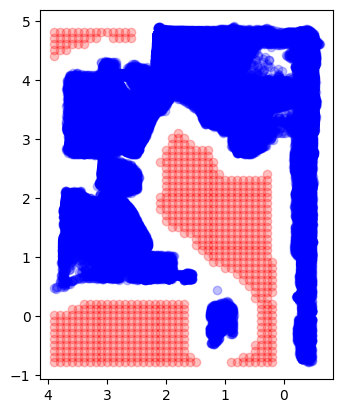

Found some valid points: (654, 2)


In [48]:
# Now figure out the points that are far enough.
coordinates = cloud.points
coordinates = coordinates[coordinates.y < 0]

# This is the cutoff used for NYU kitchen
CUTOFF = 0.65
# The PIT library is smaller
CUTOFF = 0.4

# TODO Chris: this is a hacky piece I used when the robot nav was giving me issues.
# You can use this, of course, but I recommend updating the valid points with some more constraints
# This was good enough for me.
def get_and_show_valid_points(coordinates, cutoff=CUTOFF, library=True):
    blockers = np.array([coordinates.x, coordinates.z]).T
    all_grid_points = np.array(np.meshgrid(np.arange(coordinates.x.min(), coordinates.x.max(), 0.1), np.arange(coordinates.z.min(), coordinates.z.max(), 0.1))).reshape(2, -1).T
    distance = np.linalg.norm(blockers[None, :, :] - all_grid_points[:, None, :], axis=2, ord=2)

    valid_points_index = distance.min(axis=1) > cutoff
    valid_points = all_grid_points[valid_points_index]

    ax = plt.subplot(111)
    ax.scatter(coordinates.x, coordinates.z, c="blue", alpha=0.25)
    ax.scatter(valid_points[:, 0], valid_points[:, 1], c="red", alpha = 0.25)
    ax.invert_xaxis()
    ax.set_aspect('equal', 'box')
    plt.show()
    return valid_points

valid_points = get_and_show_valid_points(coordinates)
print("Found some valid points:", valid_points.shape)


In [73]:
def find_closest_valid_point(point):
    query_point = np.array([point[0].item(), point[2].item()])
    distance = np.linalg.norm(valid_points - query_point[None, :], axis=1, ord=2)
    result = valid_points[distance.argmin()]
    return torch.Tensor((result[0], 0, result[1]))

closest_valid_pt = find_closest_valid_point(torch.Tensor([-3, 10, 0]))
print("Closest valid pt:", closest_valid_pt)

closest_valid_pt = find_closest_valid_point(home_pt)

def prune_valid_pts_library(valid_pts):
    pruned_pts = []
    for pt in valid_pts:
        y, x = pt
        if x < 2 and x > 0 and y < 3.5 and y > 0.5:
            pruned_pts.append([x, y])
    return torch.Tensor(np.array(pruned_pts))
        
valid_points = prune_valid_pts_library(valid_points)
closest_valid_pt = find_closest_valid_point(torch.Tensor([2, -1, 0]))
print("Closest valid pt:", closest_valid_pt)


Closest valid pt: tensor([0.1929, 0.0000, 0.5071])
Closest valid pt: tensor([1.9071, 0.0000, 0.5929])


In [74]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

queries = [
    # Literal
    "Armchair",
    "Typewriter",
    "Lamp",
    "Table",
    "Bookshelf",
    "Poster",

    # Visual
    "Red poster",
    "Blue book with a house on the cover",
    "The New Yorker",
    "Black and white framed photograph",
    "Hand sanitizer",
    
    # Semantic
    "Sit down and relax",
    "Write a novel",
    "Eat my dinner",
    "Put away my novel",
    "Something to read",
    "Learn about traveling",
    "Learn about the world",
    "Look out the window",
]
# TODO Chris: change to visual = True for visual queries.
visual = False
alignment_q = find_alignment_over_model(label_model, queries, points_dataloader, visual=visual)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:06<00:00, 31.29it/s]

torch.Size([19, 5809652])


torch.Size([5809652])


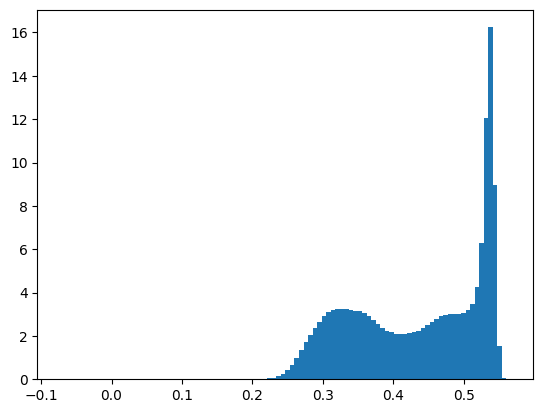

In [51]:
fig = plt.figure()
q = alignment_q[0].squeeze()
print(q.shape)
alpha = q.detach().cpu().numpy()
plt.hist(alpha, 100, density=True)

plt.show()

In [43]:
os.makedirs("visualized_pointcloud", exist_ok=True)

In [75]:
max_points = []
max_points_goto = []
mean_points = []
mean_point_goto = []
use_threshold = True
for query, q in zip(queries, alignment_q):
    alpha = q.detach().cpu().numpy()
    pts = training_data._label_xyz.detach().cpu()

    threshold = torch.quantile(q, 0.9999).cpu().item()

    # Normalize alpha
    a_norm = (alpha - alpha.min()) / (alpha.max() - alpha.min())
    a_norm = torch.as_tensor(a_norm[..., np.newaxis])
    all_colors = torch.cat((a_norm, torch.zeros_like(a_norm), 1-a_norm), dim=1)

    # TODO Chris adjust this.
    transform_add = torch.Tensor([3.0, 1.5, 1.0])
    transform_mult = torch.Tensor([-1.0, 1.0, 1.0])
    linear_transform = lambda x: transform_mult * (x+transform_add)

    if use_threshold:
        thres = alpha > threshold
        points = training_data._label_xyz[thres]
        mean_points.append(points.mean(0))
        mean_point_goto.append(find_closest_valid_point(points.mean(0)))
        # print(f"Mean GOTO {query} {linear_transform(find_closest_valid_point(points.mean(dim=0))).tolist()}")
        # print(f"Mean LOOKAT {query} {linear_transform(points).mean(dim=0).tolist()}")
        max_point = pts[torch.argmax(a_norm)]
        max_points.append(max_point)
        max_points_goto.append(find_closest_valid_point(max_point))
        print(f"GOTO {query} {linear_transform(find_closest_valid_point(max_point)).tolist()}")
        print(f"LOOKAT {query} {linear_transform(max_point).tolist()}")
        colors = all_colors[thres]
    else:
        points = training_data._label_xyz
        colors = all_colors
    merged_pcd = o3d.geometry.PointCloud()
    merged_pcd.points = o3d.utility.Vector3dVector(points)
    merged_pcd.colors = o3d.utility.Vector3dVector(colors)
    merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.01)
    visual_str = "_visual" if visual else ""
    thres_str = "_thres" if use_threshold else ""
    o3d.io.write_point_cloud(f"visualized_pointcloud/model_nyu_kitchen_{query}{visual_str}{thres_str}.ply", merged_downpcd)

GOTO Armchair [-4.9070658683776855, 1.5, 2.9928598403930664]
LOOKAT Armchair [-5.742832183837891, 0.5734451413154602, 4.712455749511719]
GOTO Typewriter [-4.9070658683776855, 1.5, 2.9928598403930664]
LOOKAT Typewriter [-5.600460052490234, 0.6337096691131592, 3.2948997020721436]
GOTO Lamp [-4.9070658683776855, 1.5, 2.7928600311279297]
LOOKAT Lamp [-6.711078643798828, 0.7272667288780212, 2.7536869049072266]
GOTO Table [-4.707066059112549, 1.5, 2.9928598403930664]
LOOKAT Table [-4.732792854309082, -0.08745324611663818, 5.18122673034668]
GOTO Bookshelf [-4.507065773010254, 1.5, 2.892859935760498]
LOOKAT Bookshelf [-2.711977243423462, 2.15448260307312, 4.5560102462768555]
GOTO Poster [-3.507065773010254, 1.5, 1.5928599834442139]
LOOKAT Poster [-2.5519566535949707, 1.8905863761901855, 2.277827024459839]
GOTO Red poster [-3.507065773010254, 1.5, 1.5928599834442139]
LOOKAT Red poster [-2.5517542362213135, 1.9115915298461914, 2.232792377471924]
GOTO Blue book with a house on the cover [-3.50706

In [76]:
from pyntcloud.plot.common import get_colors

from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.cm as cm

def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M

def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta

def set_proper_aspect_ratio(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

def plot_with_matplotlib(cloud, 
            **kwargs):

    colors = get_colors(cloud, kwargs["use_as_color"], kwargs["cmap"])

    ptp = cloud.xyz.ptp()

    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=kwargs.get("elev", 0.0), azim=kwargs.get("azim", 90.0))

    ax.scatter(
        cloud.xyz[:, 0],
        cloud.xyz[:, 1],
        cloud.xyz[:, 2],
        marker="D",
        facecolors=colors / 255,
        alpha=0.25,
        zdir="z",
        depthshade=True,
        s=kwargs["initial_point_size"] or ptp / 10)


    if "text" in kwargs:
        for i, (points, text) in enumerate(kwargs["text"]):
            ax.text(points[0], points[1], points[2], text)

    if "goto" in kwargs:
        for i, points in enumerate(kwargs["goto"]):
            draw_circle = Circle((0, 0), 0.5, fill=True, alpha=0.25, facecolor=cm.hot(i / len(kwargs["goto"])))
            ax.add_patch(draw_circle)
            pathpatch_2d_to_3d(draw_circle, 0, "y")
            pathpatch_translate(draw_circle, (points[0], 0, points[2]))

    if "title" in kwargs:
        ax.set_title(kwargs["title"])
    
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    set_proper_aspect_ratio(ax)

    return plt.show()

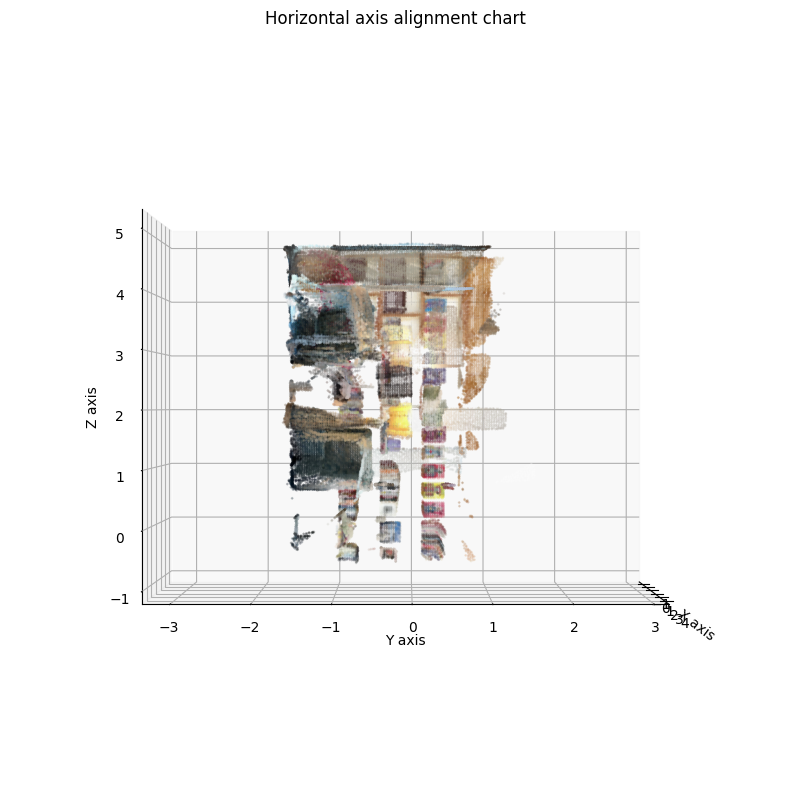

In [70]:
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=0.,
    title="Horizontal axis alignment chart",
)

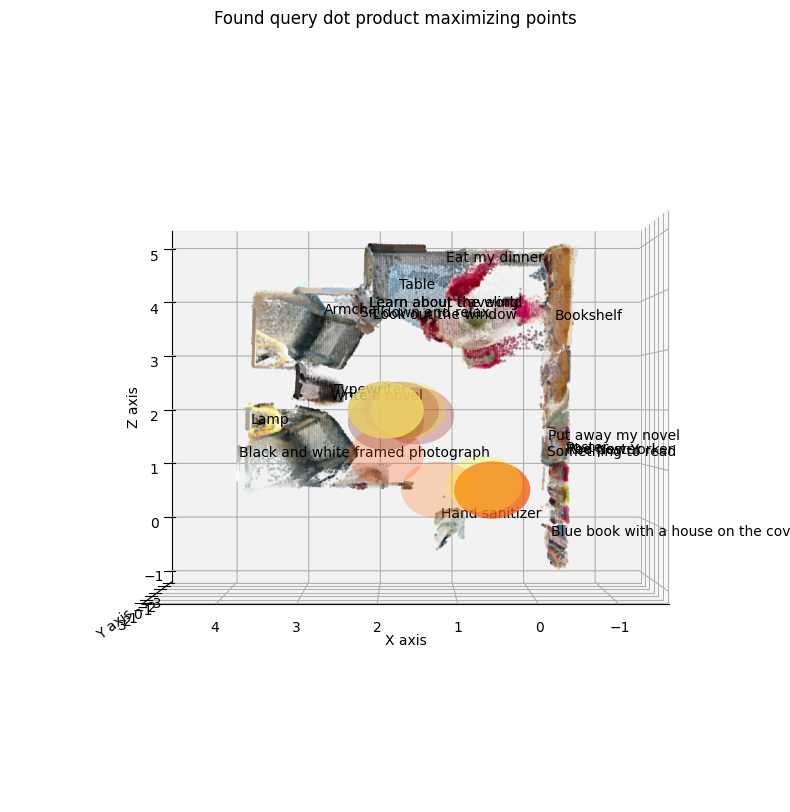

In [77]:
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=90.,
    text=zip(max_points, queries),
    title="Found query dot product maximizing points",
    goto=max_points_goto,
)

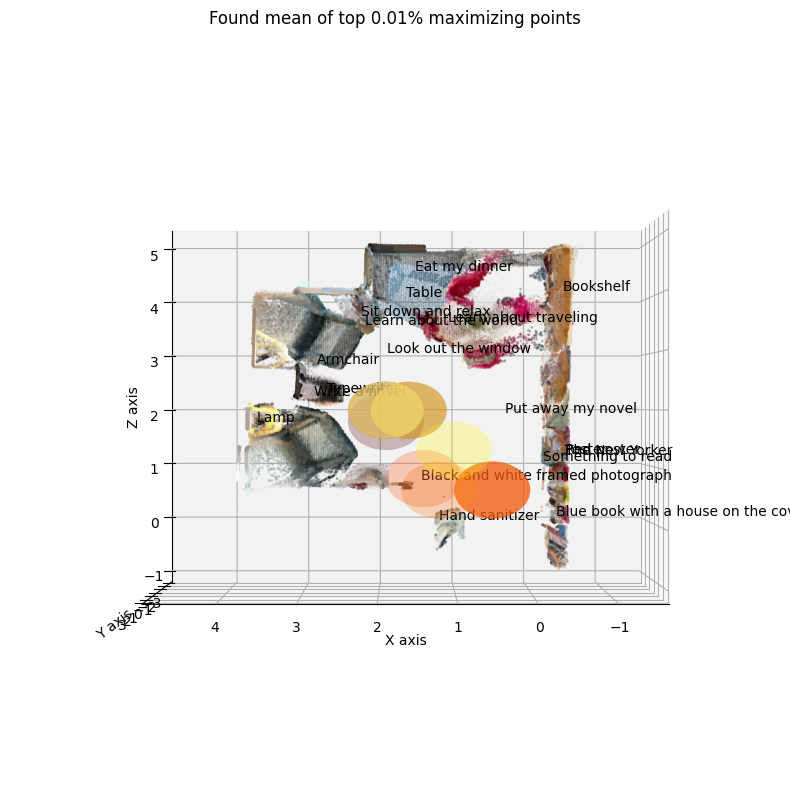

In [78]:
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=90.,
    text=zip(mean_points, queries),
    title="Found mean of top 0.01% maximizing points",
    goto=mean_point_goto,
)